# Data imputation
In this notebook the inputation algorithms implemented are shown. This step is carried out in an Jupyter notebook with an R kernel available.

In [2]:
library(readr)
library(imputeTS)

Warning message:
"package 'imputeTS' was built under R version 3.6.2"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [3]:
stacked.imputation <- function(tseries) {
  tseriesimp <- na_seadec(tseries,  algorithm = "interpolation")
  if (length(tseriesimp[tseriesimp <0])>0) {
    tseriesimp[tseriesimp <0] <-NA
    tseriesimp <- na_seadec(tseriesimp, algorithm = "mean")
  }
  return(tseriesimp)
}

Gerimputation <- function(datapath,station) {
  #Fuction to read the csv file
  df.station <-read_csv(paste(datapath, station,".csv",sep=""), 
    col_types = cols(FECHA = col_datetime(format = "%Y-%m-%d %H:%M:%S")))
  
  df.tsstation<-ts(df.station[,2:16], start = c(2012,0), frequency = 365.25*24)
  df.tsstation_imputed=df.tsstation #initialization
  for (i in 1:(dim(df.tsstation)[2])){
    df.tsstation_imputed[,i] <- stacked.imputation(df.tsstation[,i])
  }

  #for each variable perform the imputation and save in a csv and plot 
  #in a folder imputedG with subfolders data and plots.
  return(df.tsstation_imputed)
}

## Testing with the Nortweast station
Here we are going to test the imputation algorithm with the Northwest station. 

In [4]:
station_data_path="../data/Monterrey/cleaned_station/NOROESTE.csv"

NOROESTE <- read_csv(station_data_path,
    col_types = cols(FECHA = col_datetime(format = "%Y-%m-%d %H:%M:%S")))
#View(NOROESTE)

In [5]:
str(NOROESTE)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	52608 obs. of  16 variables:
 $ FECHA: POSIXct, format: "2012-01-01 00:00:00" "2012-01-01 01:00:00" ...
 $ CO   : num  2.08 5.2 2.51 3.33 1.26 0.91 1.68 1.06 0.66 0.66 ...
 $ NO   : num  16.6 154.4 47.4 96.7 10 ...
 $ NO2  : num  57.8 60.4 51.1 49 39.3 27.4 40 23.1 14.9 12.7 ...
 $ NOX  : num  74.4 214.8 98.5 145.7 49.3 ...
 $ O3   : num  5 8 4 6 7 8 3 12 22 25 ...
 $ PM10 : num  300 255 433 216 212 110 86 131 206 64 ...
 $ PM2.5: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PRS  : num  716 716 716 716 717 ...
 $ RAINF: num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH   : num  31 34 34 34 28 25 29 33 34 37 ...
 $ SO2  : num  14.5 16.5 10.9 9.9 7.5 6.4 6.7 6.5 6.5 6.4 ...
 $ SR   : num  0 0 0 0 0 0 0 0.006 0.062 0.06 ...
 $ TOUT : num  18.6 17.6 17.1 17 17.8 ...
 $ WDR  : num  330 295 332 310 317 318 281 37 111 220 ...
 $ WSR  : num  6.8 2.4 5.3 8.1 11 11.8 5.1 14.6 6 9.1 ...
 - attr(*, "spec")=
  .. cols(
  ..   FECHA = col_datetime(format = "%Y-

In [6]:
tsNOROESTE<-ts(NOROESTE, start = c(2012,0), frequency = 365.25*24)
imputed <-Gerimputation("../data/Monterrey/cleaned_station/","NOROESTE")
#save(imputed, file="../data/Monterrey/processed/NOROESTE.RData") #the time series format get lost after saving.
#write.csv(cbind(NOROESTE[,1],imputed), file="../data/Monterrey/processed/NOROESTE.csv", row.names = FALSE)

In [7]:
# Time series object to dataframe (For plotting purposes and easy handling)
imputeddf<-data.frame(as.matrix(imputed),date=time(imputed))

In [8]:
for (var in colnames(imputeddf)[-16])
{
    test_missing<-which(is.na(tsNOROESTE[,var]))
    imputeddf[,paste(var,'_miss', sep="")]<-'Not missing'
    imputeddf[test_missing,paste(var,'_miss', sep="")]<-'Missing'
}

In [9]:
head(imputeddf)

CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,...,PM10_miss,PM2.5_miss,PRS_miss,RAINF_miss,RH_miss,SO2_miss,SR_miss,TOUT_miss,WDR_miss,WSR_miss
2.08,16.6,57.8,74.4,5,300,18.55240,715.8,0,31,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
5.20,154.4,60.4,214.8,8,255,21.62368,716.2,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2.51,47.4,51.1,98.5,4,433,23.59464,716.5,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3.33,96.7,49.0,145.7,6,216,33.93142,716.5,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1.26,10.0,39.3,49.3,7,212,16.87847,716.7,0,28,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
0.91,6.2,27.4,33.6,8,110,18.43492,717.3,0,25,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


In [10]:
write.csv(imputeddf, '../data/Monterrey/processed/northweast_imputations.csv')

### Multiseasonal decomposition of PM2.5 

In [12]:
#Seasonalidad, diaria no capturada
imputeddecomposed <-decompose(imputed[,'PM2.5'])
#plot(imputeddecomposed)

In [13]:
str(imputeddecomposed)

List of 6
 $ x       : Time-Series [1:52608] from 2012 to 2018: 18.6 21.6 23.6 33.9 16.9 ...
 $ seasonal: Time-Series [1:52608] from 2012 to 2018: 16.53 35.5 10.56 3.38 4.22 ...
 $ trend   : Time-Series [1:52608] from 2012 to 2018: NA NA NA NA NA NA NA NA NA NA ...
 $ random  : Time-Series [1:52608] from 2012 to 2018: NA NA NA NA NA NA NA NA NA NA ...
 $ figure  : num [1:8766] 16.53 35.5 10.56 3.38 4.22 ...
 $ type    : chr "additive"
 - attr(*, "class")= chr "decomposed.ts"


In [19]:
library(ggfortify)
decomposedexpladf<- fortify(imputeddecomposed)

In [26]:
write.csv(decomposedexpladf, '../data/Monterrey/processed/northweast_pm5_decomposed.csv')

### Visualize imputations

All the imputations for the northwest measurement station

In [ ]:
library(ggplot2)
library(gridExtra)
library(grid)
library(lattice)

In [232]:
co_plot <-ggplot(imputeddf, aes(x=date, y=CO, color=CO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none", axis.title.x=element_text(face='plain',size=7), axis.text.x=element_text(face='plain',size=7))
no_plot <-ggplot(imputeddf, aes(x=date, y=NO, color=NO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
no2_plot <-ggplot(imputeddf, aes(x=date, y=NO2, color=NO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
nox_plot <-ggplot(imputeddf, aes(x=date, y=NOX, color=NOX_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
o3_plot <-ggplot(imputeddf, aes(x=date, y=O3, color=O3_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm10_plot <-ggplot(imputeddf, aes(x=date, y=PM10, color=PM10_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm25_plot <-ggplot(imputeddf, aes(x=date, y=PM2.5, color=PM2.5_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
psr_plot <-ggplot(imputeddf, aes(x=date, y=PRS, color=PRS_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rainf_plot <-ggplot(imputeddf, aes(x=date, y=RAINF, color=RAINF_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rh_plot <-ggplot(imputeddf, aes(x=date, y=RH, color=RH_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
so2_plot <-ggplot(imputeddf, aes(x=date, y=SO2, color=SO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() +theme(legend.position = "none")
sr_plot <-ggplot(imputeddf, aes(x=date, y=SR, color=SR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
tout_plot <-ggplot(imputeddf, aes(x=date, y=TOUT, color=TOUT_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wdr_plot <-ggplot(imputeddf, aes(x=date, y=WDR, color=WDR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wsr_plot <-ggplot(imputeddf, aes(x=date, y=WSR, color=WSR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to 

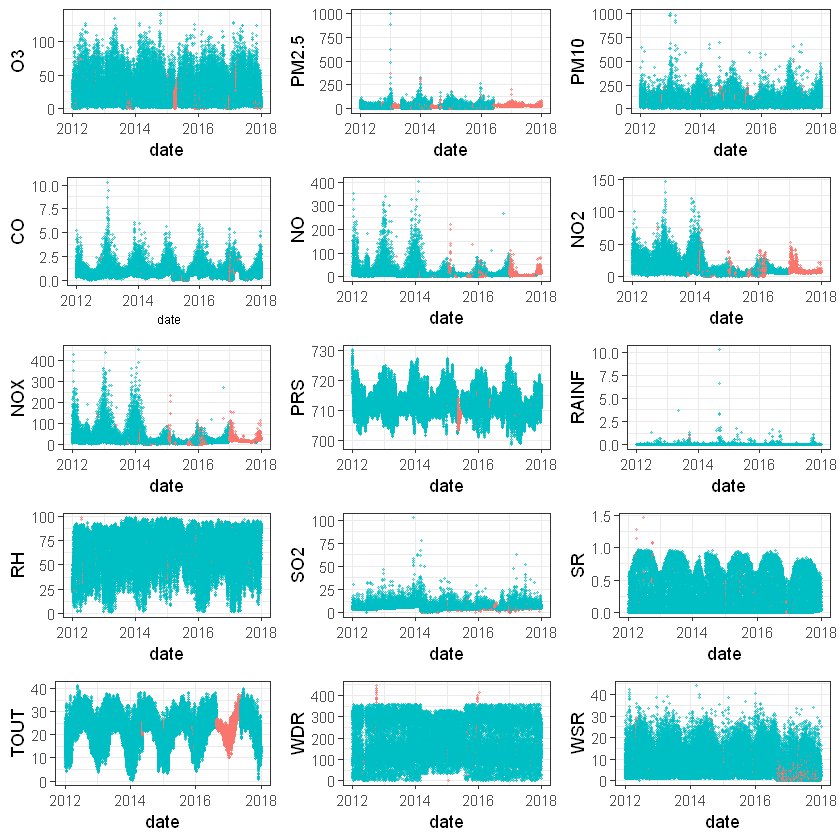

In [233]:
grid.arrange(o3_plot,pm25_plot,pm10_plot,co_plot,no_plot,no2_plot,nox_plot, psr_plot, rainf_plot, rh_plot, so2_plot, sr_plot, tout_plot, wdr_plot, wsr_plot, ncol=3)